In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
# split the data into train and test parts
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
data_df = pd.read_csv('simulation_polynomial.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [4]:
data_df

,sbj,trial,value_0,value_1,gaze_0,gaze_1,true_drift_0,true_drift_1,true_threshold,true_ndt,rt,choice
0,1,1,2.939287,3.366231,0.843796,0.156204,0.603554,0.482802,0.906172,0.244761,1.210761,1.0
1,1,2,2.561973,1.904733,0.445410,0.554590,0.658259,0.442678,0.906172,0.244761,0.582761,0.0
2,1,3,2.172226,2.793958,0.724563,0.275437,0.510557,0.570743,0.906172,0.244761,0.713761,0.0
3,1,4,3.492795,2.722823,0.074119,0.925881,0.500520,0.582188,0.906172,0.244761,0.667761,1.0
4,1,5,2.418577,2.422250,0.556938,0.443062,0.558877,0.521397,0.906172,0.244761,1.192761,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19902,100,196,2.023847,2.682980,0.105562,0.894438,0.170663,1.182253,1.609148,0.283313,0.743313,1.0
19903,100,197,1.367823,2.507903,0.627496,0.372504,0.254057,0.794181,1.609148,0.283313,0.932313,0.0
19904,100,198,3.369851,1.650198,0.269569,0.730431,0.776306,0.259907,1.609148,0.283313,3.380313,0.0
19905,100,199,1.729512,2.718103,0.931966,0.068034,0.498002,0.405154,1.609148,0.283313,0.694313,0.0


In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.3)

obs_train = np.asarray(tr_df[['rt', 'choice']])
X_train = np.asarray(tr_df[['value_0', 'value_1', 'gaze_0', 'gaze_1']])

obs_test = np.asarray(ts_df[['rt', 'choice']])
X_test = np.asarray(ts_df[['value_0', 'value_1', 'gaze_0', 'gaze_1']])

print(X_train.shape, X_test.shape)

(13926, 4) (5981, 4)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 8, 5]
input_shape = 4
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 312       
                                                                 
Total params: 605 (2.36 KB)
Trainable params: 605 (2.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
history = model.fit(X_train, obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=4500)

Epoch 1/4500
1/1 [==============================] - 486s 486s/step - loss: 82247.2188
Epoch 2/4500
1/1 [==============================] - 0s 115ms/step - loss: 81841.6094
Epoch 3/4500
1/1 [==============================] - 0s 96ms/step - loss: 81557.8906
Epoch 4/4500
1/1 [==============================] - 0s 97ms/step - loss: 81320.4609
Epoch 5/4500
1/1 [==============================] - 0s 93ms/step - loss: 81108.6016
Epoch 6/4500
1/1 [==============================] - 0s 91ms/step - loss: 80913.6406
Epoch 7/4500
1/1 [==============================] - 0s 87ms/step - loss: 80730.9297
Epoch 8/4500
1/1 [==============================] - 0s 89ms/step - loss: 80557.6250
Epoch 9/4500
1/1 [==============================] - 0s 89ms/step - loss: 80391.8047
Epoch 10/4500
1/1 [==============================] - 0s 86ms/step - loss: 80232.1172
Epoch 11/4500
1/1 [==============================] - 0s 87ms/step - loss: 80077.5703
Epoch 12/4500
1/1 [==============================] - 0s 91ms/step - los

1/1 [==============================] - 0s 135ms/step - loss: 66108.6406
Epoch 192/4500
1/1 [==============================] - 0s 133ms/step - loss: 66064.5234
Epoch 193/4500
1/1 [==============================] - 0s 270ms/step - loss: 66020.6172
Epoch 194/4500
1/1 [==============================] - 0s 159ms/step - loss: 65976.9062
Epoch 195/4500
1/1 [==============================] - 0s 138ms/step - loss: 65933.3984
Epoch 196/4500
1/1 [==============================] - 0s 127ms/step - loss: 65890.0859
Epoch 197/4500
1/1 [==============================] - 0s 129ms/step - loss: 65846.9688
Epoch 198/4500
1/1 [==============================] - 0s 129ms/step - loss: 65804.0469
Epoch 199/4500
1/1 [==============================] - 0s 126ms/step - loss: 65761.3203
Epoch 200/4500
1/1 [==============================] - 0s 125ms/step - loss: 65718.7812
Epoch 201/4500
1/1 [==============================] - 0s 126ms/step - loss: 65676.4297
Epoch 202/4500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 122ms/step - loss: 60062.7266
Epoch 380/4500
1/1 [==============================] - 0s 122ms/step - loss: 60036.1328
Epoch 381/4500
1/1 [==============================] - 0s 125ms/step - loss: 60009.5195
Epoch 382/4500
1/1 [==============================] - 0s 125ms/step - loss: 59982.8984
Epoch 383/4500
1/1 [==============================] - 0s 121ms/step - loss: 59956.2500
Epoch 384/4500
1/1 [==============================] - 0s 124ms/step - loss: 59929.5742
Epoch 385/4500
1/1 [==============================] - 0s 124ms/step - loss: 59902.8594
Epoch 386/4500
1/1 [==============================] - 0s 122ms/step - loss: 59876.0820
Epoch 387/4500
1/1 [==============================] - 0s 124ms/step - loss: 59849.2383
Epoch 388/4500
1/1 [==============================] - 0s 124ms/step - loss: 59822.3008
Epoch 389/4500
1/1 [==============================] - 0s 122ms/step - loss: 59795.2344
Epoch 390/4500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 125ms/step - loss: 54407.8906
Epoch 568/4500
1/1 [==============================] - 0s 123ms/step - loss: 54379.0469
Epoch 569/4500
1/1 [==============================] - 0s 125ms/step - loss: 54350.1562
Epoch 570/4500
1/1 [==============================] - 0s 125ms/step - loss: 54321.3672
Epoch 571/4500
1/1 [==============================] - 0s 123ms/step - loss: 54292.5391
Epoch 572/4500
1/1 [==============================] - 0s 124ms/step - loss: 54263.8086
Epoch 573/4500
1/1 [==============================] - 0s 121ms/step - loss: 54235.0312
Epoch 574/4500
1/1 [==============================] - 0s 123ms/step - loss: 54206.3594
Epoch 575/4500
1/1 [==============================] - 0s 123ms/step - loss: 54177.6406
Epoch 576/4500
1/1 [==============================] - 0s 125ms/step - loss: 54149.0273
Epoch 577/4500
1/1 [==============================] - 0s 126ms/step - loss: 54120.3555
Epoch 578/4500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 122ms/step - loss: 49850.0078
Epoch 756/4500
1/1 [==============================] - 0s 123ms/step - loss: 49830.3047
Epoch 757/4500
1/1 [==============================] - 0s 124ms/step - loss: 49810.3906
Epoch 758/4500
1/1 [==============================] - 0s 124ms/step - loss: 49790.6016
Epoch 759/4500
1/1 [==============================] - 0s 125ms/step - loss: 49770.5352
Epoch 760/4500
1/1 [==============================] - 0s 126ms/step - loss: 49750.6719
Epoch 761/4500
1/1 [==============================] - 0s 131ms/step - loss: 49730.7109
Epoch 762/4500
1/1 [==============================] - 0s 133ms/step - loss: 49711.0078
Epoch 763/4500
1/1 [==============================] - 0s 129ms/step - loss: 49691.3242
Epoch 764/4500
1/1 [==============================] - 0s 129ms/step - loss: 49671.8789
Epoch 765/4500
1/1 [==============================] - 0s 131ms/step - loss: 49652.4492
Epoch 766/4500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 123ms/step - loss: 46656.1133
Epoch 944/4500
1/1 [==============================] - 0s 125ms/step - loss: 46642.0703
Epoch 945/4500
1/1 [==============================] - 0s 124ms/step - loss: 46627.8047
Epoch 946/4500
1/1 [==============================] - 0s 125ms/step - loss: 46613.8242
Epoch 947/4500
1/1 [==============================] - 0s 124ms/step - loss: 46599.6484
Epoch 948/4500
1/1 [==============================] - 0s 122ms/step - loss: 46585.6836
Epoch 949/4500
1/1 [==============================] - 0s 126ms/step - loss: 46571.5508
Epoch 950/4500
1/1 [==============================] - 0s 126ms/step - loss: 46557.6328
Epoch 951/4500
1/1 [==============================] - 0s 126ms/step - loss: 46543.5391
Epoch 952/4500
1/1 [==============================] - 0s 124ms/step - loss: 46529.7188
Epoch 953/4500
1/1 [==============================] - 0s 121ms/step - loss: 46515.6836
Epoch 954/4500
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 128ms/step - loss: 44494.6250
Epoch 1130/4500
1/1 [==============================] - 0s 127ms/step - loss: 44485.5742
Epoch 1131/4500
1/1 [==============================] - 0s 131ms/step - loss: 44476.2656
Epoch 1132/4500
1/1 [==============================] - 0s 129ms/step - loss: 44467.2656
Epoch 1133/4500
1/1 [==============================] - 0s 126ms/step - loss: 44458.0078
Epoch 1134/4500
1/1 [==============================] - 0s 123ms/step - loss: 44449.0508
Epoch 1135/4500
1/1 [==============================] - 0s 124ms/step - loss: 44439.8438
Epoch 1136/4500
1/1 [==============================] - 0s 125ms/step - loss: 44430.9531
Epoch 1137/4500
1/1 [==============================] - 0s 128ms/step - loss: 44421.7812
Epoch 1138/4500
1/1 [==============================] - 0s 124ms/step - loss: 44412.9453
Epoch 1139/4500
1/1 [==============================] - 0s 127ms/step - loss: 44403.8125
Epoch 1140/4500
1/1 [===========================

1/1 [==============================] - 0s 125ms/step - loss: 43162.6328
Epoch 1316/4500
1/1 [==============================] - 0s 125ms/step - loss: 43157.4219
Epoch 1317/4500
1/1 [==============================] - 0s 124ms/step - loss: 43151.9414
Epoch 1318/4500
1/1 [==============================] - 0s 122ms/step - loss: 43146.7695
Epoch 1319/4500
1/1 [==============================] - 0s 123ms/step - loss: 43141.3047
Epoch 1320/4500
1/1 [==============================] - 0s 122ms/step - loss: 43136.1719
Epoch 1321/4500
1/1 [==============================] - 0s 124ms/step - loss: 43130.7344
Epoch 1322/4500
1/1 [==============================] - 0s 124ms/step - loss: 43125.6289
Epoch 1323/4500
1/1 [==============================] - 0s 124ms/step - loss: 43120.2383
Epoch 1324/4500
1/1 [==============================] - 0s 122ms/step - loss: 43115.1719
Epoch 1325/4500
1/1 [==============================] - 0s 125ms/step - loss: 43109.8008
Epoch 1326/4500
1/1 [===========================

1/1 [==============================] - 0s 131ms/step - loss: 42402.3281
Epoch 1502/4500
1/1 [==============================] - 0s 134ms/step - loss: 42399.4219
Epoch 1503/4500
1/1 [==============================] - 0s 131ms/step - loss: 42396.2930
Epoch 1504/4500
1/1 [==============================] - 0s 128ms/step - loss: 42393.3945
Epoch 1505/4500
1/1 [==============================] - 0s 130ms/step - loss: 42390.2305
Epoch 1506/4500
1/1 [==============================] - 0s 129ms/step - loss: 42387.3477
Epoch 1507/4500
1/1 [==============================] - 0s 128ms/step - loss: 42384.2109
Epoch 1508/4500
1/1 [==============================] - 0s 130ms/step - loss: 42381.3594
Epoch 1509/4500
1/1 [==============================] - 0s 130ms/step - loss: 42378.2383
Epoch 1510/4500
1/1 [==============================] - 0s 132ms/step - loss: 42375.4531
Epoch 1511/4500
1/1 [==============================] - 0s 133ms/step - loss: 42372.3477
Epoch 1512/4500
1/1 [===========================

1/1 [==============================] - 0s 122ms/step - loss: 41958.1250
Epoch 1688/4500
1/1 [==============================] - 0s 124ms/step - loss: 41956.3711
Epoch 1689/4500
1/1 [==============================] - 0s 168ms/step - loss: 41954.4023
Epoch 1690/4500
1/1 [==============================] - 0s 125ms/step - loss: 41952.6875
Epoch 1691/4500
1/1 [==============================] - 0s 126ms/step - loss: 41950.6953
Epoch 1692/4500
1/1 [==============================] - 0s 135ms/step - loss: 41948.9492
Epoch 1693/4500
1/1 [==============================] - 0s 129ms/step - loss: 41947.0430
Epoch 1694/4500
1/1 [==============================] - 0s 125ms/step - loss: 41945.3672
Epoch 1695/4500
1/1 [==============================] - 0s 128ms/step - loss: 41943.3516
Epoch 1696/4500
1/1 [==============================] - 0s 138ms/step - loss: 41941.7109
Epoch 1697/4500
1/1 [==============================] - 0s 132ms/step - loss: 41939.6680
Epoch 1698/4500
1/1 [===========================

1/1 [==============================] - 0s 124ms/step - loss: 41679.1250
Epoch 1874/4500
1/1 [==============================] - 0s 125ms/step - loss: 41678.0391
Epoch 1875/4500
1/1 [==============================] - 0s 127ms/step - loss: 41676.7266
Epoch 1876/4500
1/1 [==============================] - 0s 124ms/step - loss: 41675.6328
Epoch 1877/4500
1/1 [==============================] - 0s 125ms/step - loss: 41674.2773
Epoch 1878/4500
1/1 [==============================] - 0s 121ms/step - loss: 41673.3203
Epoch 1879/4500
1/1 [==============================] - 0s 125ms/step - loss: 41671.9883
Epoch 1880/4500
1/1 [==============================] - 0s 122ms/step - loss: 41670.9453
Epoch 1881/4500
1/1 [==============================] - 0s 124ms/step - loss: 41669.6211
Epoch 1882/4500
1/1 [==============================] - 0s 126ms/step - loss: 41668.5859
Epoch 1883/4500
1/1 [==============================] - 0s 122ms/step - loss: 41667.2773
Epoch 1884/4500
1/1 [===========================

1/1 [==============================] - 0s 131ms/step - loss: 41496.1992
Epoch 2060/4500
1/1 [==============================] - 0s 127ms/step - loss: 41495.4023
Epoch 2061/4500
1/1 [==============================] - 0s 130ms/step - loss: 41494.5391
Epoch 2062/4500
1/1 [==============================] - 0s 131ms/step - loss: 41493.7578
Epoch 2063/4500
1/1 [==============================] - 0s 134ms/step - loss: 41492.7227
Epoch 2064/4500
1/1 [==============================] - 0s 140ms/step - loss: 41492.1172
Epoch 2065/4500
1/1 [==============================] - 0s 132ms/step - loss: 41491.1211
Epoch 2066/4500
1/1 [==============================] - 0s 131ms/step - loss: 41490.6016
Epoch 2067/4500
1/1 [==============================] - 0s 130ms/step - loss: 41489.6719
Epoch 2068/4500
1/1 [==============================] - 0s 126ms/step - loss: 41489.2148
Epoch 2069/4500
1/1 [==============================] - 0s 129ms/step - loss: 41488.0625
Epoch 2070/4500
1/1 [===========================

1/1 [==============================] - 0s 126ms/step - loss: 41372.7617
Epoch 2246/4500
1/1 [==============================] - 0s 126ms/step - loss: 41372.2734
Epoch 2247/4500
1/1 [==============================] - 0s 125ms/step - loss: 41371.5703
Epoch 2248/4500
1/1 [==============================] - 0s 127ms/step - loss: 41371.1992
Epoch 2249/4500
1/1 [==============================] - 0s 125ms/step - loss: 41370.6641
Epoch 2250/4500
1/1 [==============================] - 0s 127ms/step - loss: 41370.2188
Epoch 2251/4500
1/1 [==============================] - 0s 123ms/step - loss: 41369.6445
Epoch 2252/4500
1/1 [==============================] - 0s 126ms/step - loss: 41369.1172
Epoch 2253/4500
1/1 [==============================] - 0s 126ms/step - loss: 41368.5078
Epoch 2254/4500
1/1 [==============================] - 0s 125ms/step - loss: 41367.9648
Epoch 2255/4500
1/1 [==============================] - 0s 125ms/step - loss: 41367.2578
Epoch 2256/4500
1/1 [===========================

1/1 [==============================] - 0s 128ms/step - loss: 41288.6172
Epoch 2432/4500
1/1 [==============================] - 0s 122ms/step - loss: 41288.2891
Epoch 2433/4500
1/1 [==============================] - 0s 125ms/step - loss: 41287.7422
Epoch 2434/4500
1/1 [==============================] - 0s 125ms/step - loss: 41287.6016
Epoch 2435/4500
1/1 [==============================] - 0s 124ms/step - loss: 41287.2656
Epoch 2436/4500
1/1 [==============================] - 0s 121ms/step - loss: 41287.2188
Epoch 2437/4500
1/1 [==============================] - 0s 124ms/step - loss: 41286.3633
Epoch 2438/4500
1/1 [==============================] - 0s 122ms/step - loss: 41286.2852
Epoch 2439/4500
1/1 [==============================] - 0s 121ms/step - loss: 41285.6484
Epoch 2440/4500
1/1 [==============================] - 0s 120ms/step - loss: 41285.4453
Epoch 2441/4500
1/1 [==============================] - 0s 125ms/step - loss: 41284.7148
Epoch 2442/4500
1/1 [===========================

1/1 [==============================] - 0s 128ms/step - loss: 41229.7539
Epoch 2618/4500
1/1 [==============================] - 0s 132ms/step - loss: 41229.5156
Epoch 2619/4500
1/1 [==============================] - 0s 123ms/step - loss: 41229.2031
Epoch 2620/4500
1/1 [==============================] - 0s 130ms/step - loss: 41229.2461
Epoch 2621/4500
1/1 [==============================] - 0s 125ms/step - loss: 41229.0742
Epoch 2622/4500
1/1 [==============================] - 0s 125ms/step - loss: 41229.1953
Epoch 2623/4500
1/1 [==============================] - 0s 150ms/step - loss: 41228.6211
Epoch 2624/4500
1/1 [==============================] - 0s 140ms/step - loss: 41228.4219
Epoch 2625/4500
1/1 [==============================] - 0s 134ms/step - loss: 41227.7852
Epoch 2626/4500
1/1 [==============================] - 0s 132ms/step - loss: 41227.4609
Epoch 2627/4500
1/1 [==============================] - 0s 307ms/step - loss: 41227.4062
Epoch 2628/4500
1/1 [===========================

1/1 [==============================] - 0s 127ms/step - loss: 41187.8281
Epoch 2804/4500
1/1 [==============================] - 0s 124ms/step - loss: 41187.7852
Epoch 2805/4500
1/1 [==============================] - 0s 124ms/step - loss: 41188.1367
Epoch 2806/4500
1/1 [==============================] - 0s 121ms/step - loss: 41188.0312
Epoch 2807/4500
1/1 [==============================] - 0s 123ms/step - loss: 41187.8633
Epoch 2808/4500
1/1 [==============================] - 0s 128ms/step - loss: 41187.5859
Epoch 2809/4500
1/1 [==============================] - 0s 123ms/step - loss: 41186.5938
Epoch 2810/4500
1/1 [==============================] - 0s 122ms/step - loss: 41187.1406
Epoch 2811/4500
1/1 [==============================] - 0s 123ms/step - loss: 41186.8047
Epoch 2812/4500
1/1 [==============================] - 0s 123ms/step - loss: 41186.6328
Epoch 2813/4500
1/1 [==============================] - 0s 123ms/step - loss: 41186.8555
Epoch 2814/4500
1/1 [===========================

1/1 [==============================] - 0s 127ms/step - loss: 41159.5859
Epoch 2990/4500
1/1 [==============================] - 0s 126ms/step - loss: 41159.8477
Epoch 2991/4500
1/1 [==============================] - 0s 125ms/step - loss: 41160.1758
Epoch 2992/4500
1/1 [==============================] - 0s 125ms/step - loss: 41159.7695
Epoch 2993/4500
1/1 [==============================] - 0s 125ms/step - loss: 41159.2539
Epoch 2994/4500
1/1 [==============================] - 0s 122ms/step - loss: 41158.8672
Epoch 2995/4500
1/1 [==============================] - 0s 124ms/step - loss: 41158.3633
Epoch 2996/4500
1/1 [==============================] - 0s 124ms/step - loss: 41158.6328
Epoch 2997/4500
1/1 [==============================] - 0s 129ms/step - loss: 41158.6992
Epoch 2998/4500
1/1 [==============================] - 0s 123ms/step - loss: 41158.1602
Epoch 2999/4500
1/1 [==============================] - 0s 125ms/step - loss: 41158.2695
Epoch 3000/4500
1/1 [===========================

1/1 [==============================] - 0s 126ms/step - loss: 41139.9219
Epoch 3176/4500
1/1 [==============================] - 0s 128ms/step - loss: 41139.8125
Epoch 3177/4500
1/1 [==============================] - 0s 125ms/step - loss: 41139.2344
Epoch 3178/4500
1/1 [==============================] - 0s 127ms/step - loss: 41138.9453
Epoch 3179/4500
1/1 [==============================] - 0s 129ms/step - loss: 41139.2266
Epoch 3180/4500
1/1 [==============================] - 0s 193ms/step - loss: 41139.1953
Epoch 3181/4500
1/1 [==============================] - 0s 128ms/step - loss: 41139.7344
Epoch 3182/4500
1/1 [==============================] - 0s 127ms/step - loss: 41139.9805
Epoch 3183/4500
1/1 [==============================] - 0s 124ms/step - loss: 41139.8438
Epoch 3184/4500
1/1 [==============================] - 0s 127ms/step - loss: 41140.2461
Epoch 3185/4500
1/1 [==============================] - 0s 131ms/step - loss: 41138.9453
Epoch 3186/4500
1/1 [===========================

1/1 [==============================] - 0s 127ms/step - loss: 41125.8750
Epoch 3362/4500
1/1 [==============================] - 0s 125ms/step - loss: 41124.4883
Epoch 3363/4500
1/1 [==============================] - 0s 121ms/step - loss: 41124.6406
Epoch 3364/4500
1/1 [==============================] - 0s 122ms/step - loss: 41123.9336
Epoch 3365/4500
1/1 [==============================] - 0s 124ms/step - loss: 41124.0156
Epoch 3366/4500
1/1 [==============================] - 0s 124ms/step - loss: 41124.7539
Epoch 3367/4500
1/1 [==============================] - 0s 123ms/step - loss: 41124.7109
Epoch 3368/4500
1/1 [==============================] - 0s 126ms/step - loss: 41124.2930
Epoch 3369/4500
1/1 [==============================] - 0s 127ms/step - loss: 41124.7031
Epoch 3370/4500
1/1 [==============================] - 0s 125ms/step - loss: 41125.2539
Epoch 3371/4500
1/1 [==============================] - 0s 124ms/step - loss: 41125.1016
Epoch 3372/4500
1/1 [===========================

1/1 [==============================] - 0s 125ms/step - loss: 41114.1406
Epoch 3548/4500
1/1 [==============================] - 0s 126ms/step - loss: 41112.9922
Epoch 3549/4500
1/1 [==============================] - 0s 126ms/step - loss: 41114.0469
Epoch 3550/4500
1/1 [==============================] - 0s 127ms/step - loss: 41112.5117
Epoch 3551/4500
1/1 [==============================] - 0s 129ms/step - loss: 41113.3906
Epoch 3552/4500
1/1 [==============================] - 0s 124ms/step - loss: 41113.9570
Epoch 3553/4500
1/1 [==============================] - 0s 183ms/step - loss: 41114.4531
Epoch 3554/4500
1/1 [==============================] - 0s 131ms/step - loss: 41114.6602
Epoch 3555/4500
1/1 [==============================] - 0s 125ms/step - loss: 41115.1992
Epoch 3556/4500
1/1 [==============================] - 0s 124ms/step - loss: 41115.4336
Epoch 3557/4500
1/1 [==============================] - 0s 127ms/step - loss: 41114.7188
Epoch 3558/4500
1/1 [===========================

1/1 [==============================] - 0s 125ms/step - loss: 41106.9375
Epoch 3734/4500
1/1 [==============================] - 0s 126ms/step - loss: 41106.5391
Epoch 3735/4500
1/1 [==============================] - 0s 125ms/step - loss: 41105.9492
Epoch 3736/4500
1/1 [==============================] - 0s 126ms/step - loss: 41105.4961
Epoch 3737/4500
1/1 [==============================] - 0s 123ms/step - loss: 41104.9805
Epoch 3738/4500
1/1 [==============================] - 0s 120ms/step - loss: 41107.2969
Epoch 3739/4500
1/1 [==============================] - 0s 125ms/step - loss: 41106.2422
Epoch 3740/4500
1/1 [==============================] - 0s 125ms/step - loss: 41106.3672
Epoch 3741/4500
1/1 [==============================] - 0s 123ms/step - loss: 41105.9492
Epoch 3742/4500
1/1 [==============================] - 0s 124ms/step - loss: 41105.6484
Epoch 3743/4500
1/1 [==============================] - 0s 123ms/step - loss: 41104.4922
Epoch 3744/4500
1/1 [===========================

1/1 [==============================] - 0s 130ms/step - loss: 41098.2500
Epoch 3920/4500
1/1 [==============================] - 0s 136ms/step - loss: 41097.3555
Epoch 3921/4500
1/1 [==============================] - 0s 136ms/step - loss: 41096.9609
Epoch 3922/4500
1/1 [==============================] - 0s 127ms/step - loss: 41097.2734
Epoch 3923/4500
1/1 [==============================] - 0s 130ms/step - loss: 41096.6602
Epoch 3924/4500
1/1 [==============================] - 0s 132ms/step - loss: 41097.2227
Epoch 3925/4500
1/1 [==============================] - 0s 129ms/step - loss: 41097.2266
Epoch 3926/4500
1/1 [==============================] - 0s 127ms/step - loss: 41097.8672
Epoch 3927/4500
1/1 [==============================] - 0s 125ms/step - loss: 41097.4062
Epoch 3928/4500
1/1 [==============================] - 0s 134ms/step - loss: 41098.8906
Epoch 3929/4500
1/1 [==============================] - 0s 126ms/step - loss: 41098.4766
Epoch 3930/4500
1/1 [===========================

1/1 [==============================] - 0s 130ms/step - loss: 41091.5156
Epoch 4106/4500
1/1 [==============================] - 0s 126ms/step - loss: 41091.2109
Epoch 4107/4500
1/1 [==============================] - 0s 125ms/step - loss: 41091.1602
Epoch 4108/4500
1/1 [==============================] - 0s 125ms/step - loss: 41090.6992
Epoch 4109/4500
1/1 [==============================] - 0s 123ms/step - loss: 41090.5156
Epoch 4110/4500
1/1 [==============================] - 0s 127ms/step - loss: 41091.6953
Epoch 4111/4500
1/1 [==============================] - 0s 122ms/step - loss: 41091.2305
Epoch 4112/4500
1/1 [==============================] - 0s 123ms/step - loss: 41092.6562
Epoch 4113/4500
1/1 [==============================] - 0s 129ms/step - loss: 41093.1133
Epoch 4114/4500
1/1 [==============================] - 0s 125ms/step - loss: 41094.4375
Epoch 4115/4500
1/1 [==============================] - 0s 121ms/step - loss: 41094.2031
Epoch 4116/4500
1/1 [===========================

1/1 [==============================] - 0s 123ms/step - loss: 41086.9844
Epoch 4292/4500
1/1 [==============================] - 0s 120ms/step - loss: 41085.8594
Epoch 4293/4500
1/1 [==============================] - 0s 125ms/step - loss: 41086.2500
Epoch 4294/4500
1/1 [==============================] - 0s 122ms/step - loss: 41087.2812
Epoch 4295/4500
1/1 [==============================] - 0s 124ms/step - loss: 41086.5078
Epoch 4296/4500
1/1 [==============================] - 0s 125ms/step - loss: 41088.7188
Epoch 4297/4500
1/1 [==============================] - 0s 124ms/step - loss: 41088.8281
Epoch 4298/4500
1/1 [==============================] - 0s 127ms/step - loss: 41088.3047
Epoch 4299/4500
1/1 [==============================] - 0s 127ms/step - loss: 41087.3125
Epoch 4300/4500
1/1 [==============================] - 0s 125ms/step - loss: 41089.5312
Epoch 4301/4500
1/1 [==============================] - 0s 126ms/step - loss: 41088.4453
Epoch 4302/4500
1/1 [===========================

1/1 [==============================] - 0s 124ms/step - loss: 41082.7383
Epoch 4478/4500
1/1 [==============================] - 0s 131ms/step - loss: 41082.7773
Epoch 4479/4500
1/1 [==============================] - 0s 130ms/step - loss: 41081.6680
Epoch 4480/4500
1/1 [==============================] - 0s 130ms/step - loss: 41083.6016
Epoch 4481/4500
1/1 [==============================] - 0s 130ms/step - loss: 41083.8281
Epoch 4482/4500
1/1 [==============================] - 0s 128ms/step - loss: 41084.7031
Epoch 4483/4500
1/1 [==============================] - 0s 133ms/step - loss: 41084.2344
Epoch 4484/4500
1/1 [==============================] - 0s 132ms/step - loss: 41082.8281
Epoch 4485/4500
1/1 [==============================] - 0s 132ms/step - loss: 41082.6719
Epoch 4486/4500
1/1 [==============================] - 0s 125ms/step - loss: 41082.8281
Epoch 4487/4500
1/1 [==============================] - 0s 131ms/step - loss: 41081.7852
Epoch 4488/4500
1/1 [===========================

0.8680690460651828 0.8060259513000981
0.9410511050728181 0.9230078173290942


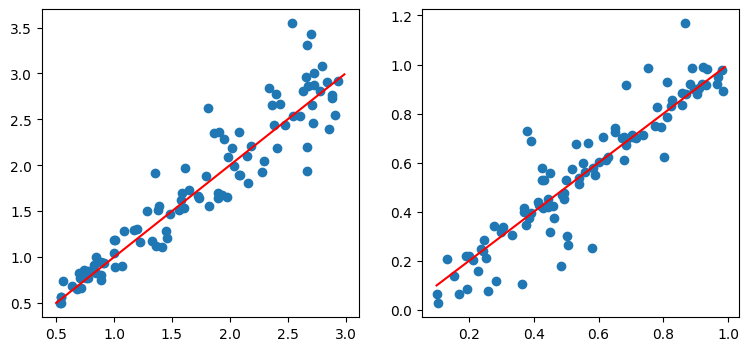

In [10]:
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))

print(r2_score(tr_df.groupby(by='sbj')['true_threshold'].mean(), threshold), 
      r2_score(tr_df.groupby(by='sbj')['true_ndt'].mean(), ndt))

print(pearsonr(tr_df.groupby(by='sbj')['true_threshold'].mean(), threshold)[0], 
      pearsonr(tr_df.groupby(by='sbj')['true_ndt'].mean(), ndt)[0])

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(tr_df.groupby(by='sbj')['true_threshold'].mean(), threshold)
plt.plot(np.arange(0.5, 3, 0.01), np.arange(0.5, 3, 0.01), c='red');

plt.subplot(122)
plt.scatter(tr_df.groupby(by='sbj')['true_ndt'].mean(), ndt)
plt.plot(np.arange(0.1, 1, 0.01), np.arange(0.1, 1, 0.01), c='red');

436/436 [==============================] - 0s 266us/step
0.7384334782726953 0.7392346267900562
0.8684266869081491 0.8700333065969743


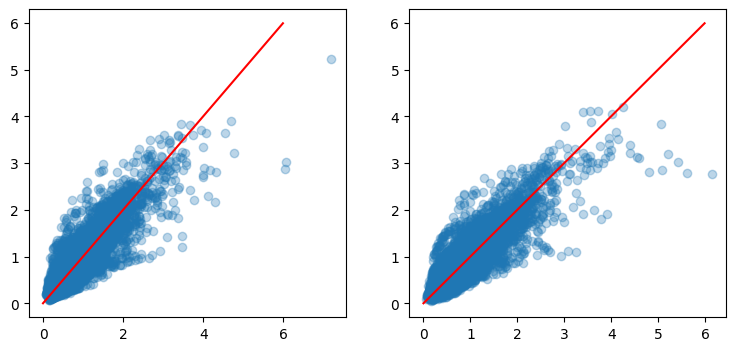

In [11]:
pred_v = model.predict(X_train)
scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in tr_df['sbj']])

print(r2_score(tr_df['true_drift_0'], scaling*pred_v[:, 0]), 
      r2_score(tr_df['true_drift_1'], scaling*pred_v[:, 1]))

print(pearsonr(tr_df['true_drift_0'], scaling*pred_v[:, 0])[0], 
      pearsonr(tr_df['true_drift_1'], scaling*pred_v[:, 1])[0])

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(tr_df['true_drift_0'], scaling*pred_v[:, 0], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

plt.subplot(122)
plt.scatter(tr_df['true_drift_1'], scaling*pred_v[:, 1], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

187/187 [==============================] - 0s 265us/step
0.7430087792722191 0.742936757904261
0.8692798455580829 0.8711240176584384


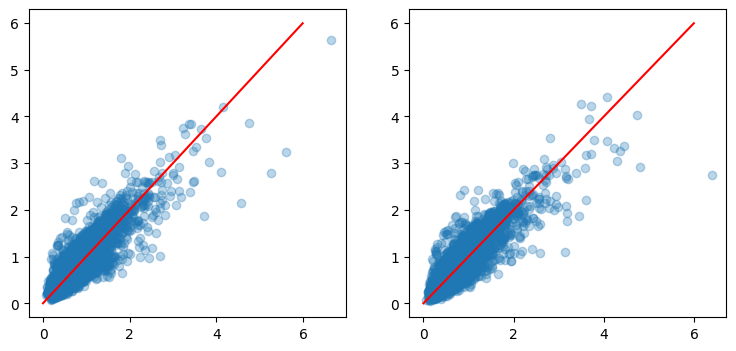

In [12]:
pred_v = model.predict(X_test)
scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

print(r2_score(ts_df['true_drift_0'], scaling*pred_v[:, 0]), 
      r2_score(ts_df['true_drift_1'], scaling*pred_v[:, 1]))

print(pearsonr(ts_df['true_drift_0'], scaling*pred_v[:, 0])[0], 
      pearsonr(ts_df['true_drift_1'], scaling*pred_v[:, 1])[0])

plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.scatter(ts_df['true_drift_0'], scaling*pred_v[:, 0], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');

plt.subplot(122)
plt.scatter(ts_df['true_drift_1'], scaling*pred_v[:, 1], alpha=0.3);
plt.plot(np.arange(0, 6, 0.01), np.arange(0, 6, 0.01), c='red');